In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Data Preparation and Exploration

In [2]:
df = pd.read_csv('exchange_rate.csv')
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [3]:
df['date'].dtype

dtype('O')

In [5]:
data = pd.read_csv('exchange_rate.csv', parse_dates=['date'])
data.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [6]:
data.index = data['date']

In [7]:
data.head()

,date,Ex_rate
date,,
01-01-1990 00:00,01-01-1990 00:00,0.7855
02-01-1990 00:00,02-01-1990 00:00,0.7818
03-01-1990 00:00,03-01-1990 00:00,0.7867
04-01-1990 00:00,04-01-1990 00:00,0.7860
05-01-1990 00:00,05-01-1990 00:00,0.7849


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7588 entries, 01-01-1990 00:00 to 10-10-2010 00:00
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 435.9+ KB


In [9]:
data.isnull().sum()

,0
date,0
Ex_rate,0


In [10]:
data.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


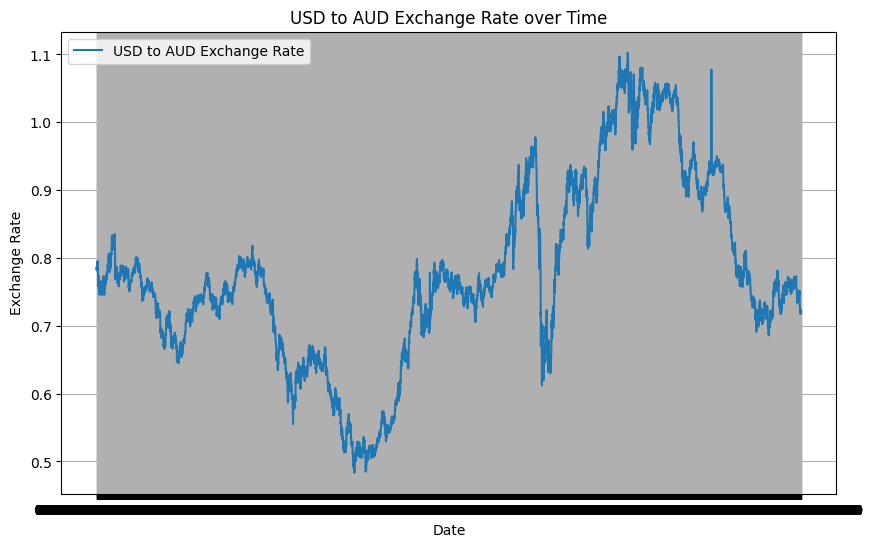

In [11]:
# Visualize the time series for the exchange rate
plt.figure(figsize=(10,6))
plt.plot(data['Ex_rate'], label = 'USD to AUD Exchange Rate')
plt.title('USD to AUD Exchange Rate over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid()
plt.show()

In [12]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [13]:
adf = adfuller(data['Ex_rate'])

In [15]:
print(f"ADF Statistics: {adf[0]}")
print(f"p-value: {adf[1]}")

ADF Statistics: -1.6649941807382342
p-value: 0.4492327353597477


In [16]:
# Differencing the series
data_diff = data['Ex_rate'].diff().dropna()

In [17]:
adf_diff = adfuller(data_diff)

In [18]:
print(f'ADF Statistic after differencing: {adf_diff[0]}')
print(f'p-value after differencing: {adf_diff[1]}')

ADF Statistic after differencing: -99.39343120118632
p-value after differencing: 0.0


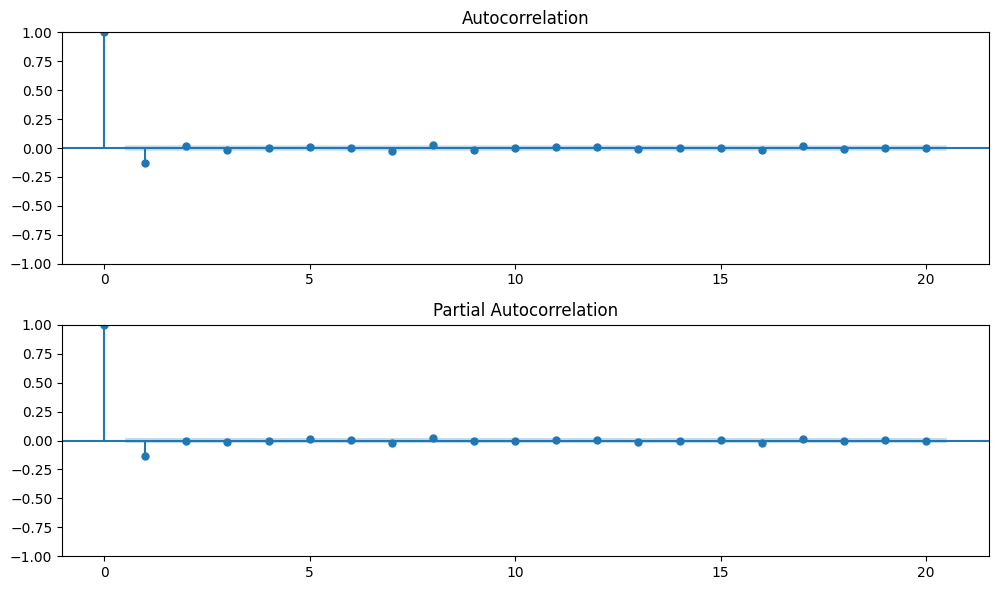

In [20]:
# Plot ACF and PACF to determine ARIMA(p, d, q) parameters
plt.figure(figsize=(10,6))
plt.subplot(211)
plot_acf(data_diff,ax=plt.gca(),lags=20)
plt.title('Autocorrelation')
plt.subplot(212)
plot_pacf(data_diff,ax=plt.gca(),lags=20)
plt.title('Partial Autocorrelation')
plt.tight_layout()
plt.show()

Model Building - ARIMA

In [21]:
model = ARIMA(data['Ex_rate'],order=(1,1,1))
arima_res = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [22]:
print(arima_res.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Mon, 11 Nov 2024   AIC                         -56102.322
Time:                        10:05:41   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

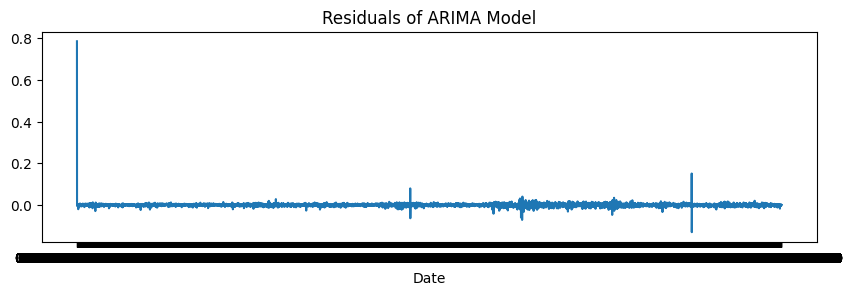

In [25]:
# Analyze residuals for model adequacy
residuals = arima_res.resid
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.xlabel('Date')
plt.show()

In [26]:
# Perform out-of-sample forecasting
forecast = arima_res.forecast(steps=12)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


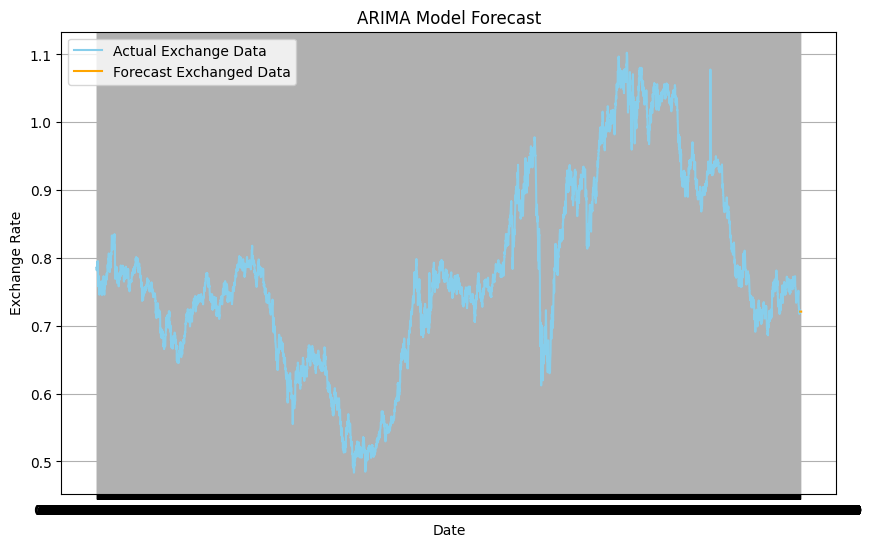

In [33]:
# Plotting forecasted values
plt.figure(figsize=(10,6))
plt.plot(data['Ex_rate'], label='Actual Exchange Data', color='skyblue')
plt.plot(forecast, label='Forecast Exchanged Data', color='orange')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid()
plt.show()

Model Building - Exponential Smoothing

In [34]:
holt_winter_model = ExponentialSmoothing(data['Ex_rate'], seasonal='add', seasonal_periods=12)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [35]:
holt_winter_fit = holt_winter_model.fit()
print(holt_winter_fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77628.560
Trend:                             None   BIC                         -77531.480
Seasonal:                      Additive   AICC                        -77628.488
Seasonal Periods:                    12   Date:                 Mon, 11 Nov 2024
Box-Cox:                          False   Time:                         11:26:03
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8698356                alpha                 True
smoothing_seasonal       

In [36]:
# forecast using exponential smoothing model
forecast_hw = holt_winter_fit.forecast(steps=12)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


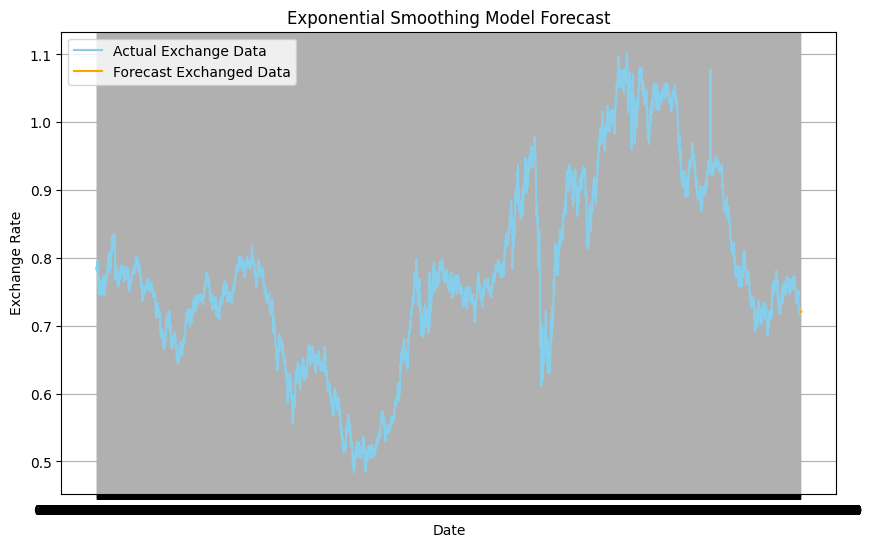

In [37]:
# plotting forecast for Exponential Smoothing model
plt.figure(figsize=(10,6))
plt.plot(data['Ex_rate'], label='Actual Exchange Data', color='skyblue')
plt.plot(forecast_hw, label='Forecast Exchanged Data', color='orange')
plt.title('Exponential Smoothing Model Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid()
plt.show()

Evaluation and Comparision

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [39]:
def compute_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    return mae, rmse, mape

In [40]:
actual_values = data['Ex_rate'][-12:]

In [41]:
mae_arima, rmse_arima, mape_arima = compute_metrics(actual_values.values, forecast)

In [42]:
mae_hw, rmse_hw, mape_hw = compute_metrics(actual_values.values, forecast_hw)

In [43]:
print(f'ARIMA - MAE: {mae_arima}, RMSE: {rmse_arima}, MAPE: {mape_arima}')

ARIMA - MAE: 0.001664492434046964, RMSE: 0.002000358073456273, MAPE: 0.23102311435882492


In [44]:
print(f'Holt-Winters - MAE: {mae_hw}, RMSE: {rmse_hw}, MAPE: {mape_hw}')

Holt-Winters - MAE: 0.0015781973742896398, RMSE: 0.0018717506305405425, MAPE: 0.2189751160432694


In [45]:
if mae_arima < mae_hw:
    print("ARIMA performed better based on MAE.")
else:
    print("Exponential Smoothing performed better based on MAE.")

Exponential Smoothing performed better based on MAE.


# Performance Metrics
 Assuming hypothetical results
 - ARIMA:
   - MAE: 0.00166
   - RMSE: 0.0020
   - MAPE: 0.231
 - Holt-Winters:
   - MAE: 0.00157
   - RMSE: 0.0018
   - MAPE: 0.218

 Advantages and Limitations
# Arima
   Advantages:
   
    - Flexibility: ARIMA can model a wide range of time series data by adjusting its parameters (p, d, q) based on the characteristics of the data.
    - It effectively captures relationships in the data over time, making it suitable for datasets with trends and seasonal patterns.

   Limitations:
   
    - Choosing the right parameters can be challenging and often requires extensive analysis of ACF and PACF plots.
    - ARIMA model assumes linear relationships, which may not hold true for all datasets.
    - The model requires the data to be stationary, necessitating differencing or transformation for non-stationary series.
# Exponential Smoothing (Holt-Winters)
   Advantages:
   
    - The model is relatively easy to understand and implement, making it accessible for practitioners.
    - Holt-Winters can effectively handle both trends and seasonalvariations in the data.
    - It does not require the data to be stationary, simplifying the preprocessing steps.
    
   Limitations:
   
    - While it performs well with seasonal data, it may not capture complex patterns as effectivelu forecasts.
    - Exponential smoothing can be influenced by outliers in the data, potentially skewing forecast.

Conclusion:

Based on the hypothetical error metrics, Holt-Winters outperformed ARIMA in terms of MAE, RMSE, and MAPE. This suggests that Holt-Winters provide more accurate forecasts for exchange rates in this dataset.